In [35]:
import sys,os
sys.path.append(os.path.abspath("../"))
sys.path.append(os.path.abspath('../modules/'))
import healpy as h
from modules.flat_sky_codes import tangent_plane_analysis as tpa
from modules.flat_sky_codes import flat_sky_analysis as fsa
from modules.masking import gen_masks as gm
from modules.settings import global_mmf_settings as gset
from data_preprocess import tiling_the_sphere as tts
from data_preprocess import tile_planck_data as tpd
from simulate import cluster_templates as cltemp
from filters import modular_multi_matched_filter as mmf
from data_preprocess import get_tangent_planes as gtp
from data_preprocess import tiling_the_sphere as tts
from simulate.spatial_template import sim_cluster as sc
from astropy.io import fits
from simulate.spatial_template import sz_pressure_profile as szp
from read_write_dict import write_dict
from read_write_dict import read_dict
import multiprocessing as mp
import collections



from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle
def colorbar(mappable):
	ax = mappable.axes
	fig = ax.figure
	divider = make_axes_locatable(ax)
	cax = divider.append_axes("right", size="5%", pad=0.05)
	return fig.colorbar(mappable, cax=cax)


def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

figpath="../../../../documents/automated_cluster_detection/figures/"

ensure_dir(figpath)
%pylab notebook


Populating the interactive namespace from numpy and matplotlib


In [2]:
dataset="planck_pr3"
whichch="hfi"
mask_point_sources=False
numprocs=35

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"
    
    
figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False

figstamp,dir_suffix

outpath="/results/" + dataset + "/planck_cat_" + dir_suffix + "/"
tempdatapath="/tempdata/" + dataset + "/planck_tiles/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=15.,do_band_pass=True,use_psf_data=use_psf_data)
figpath=gset.mmfset.paths["result_figs"]
datapath=gset.mmfset.paths["result_data"]

In [3]:
gset.mmfset.paths["result_data"]

'/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF//results/planck_pr3/planck_cat_hfi_inpainted_data/15deg_patches//data/'

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


<IPython.core.display.Javascript object>


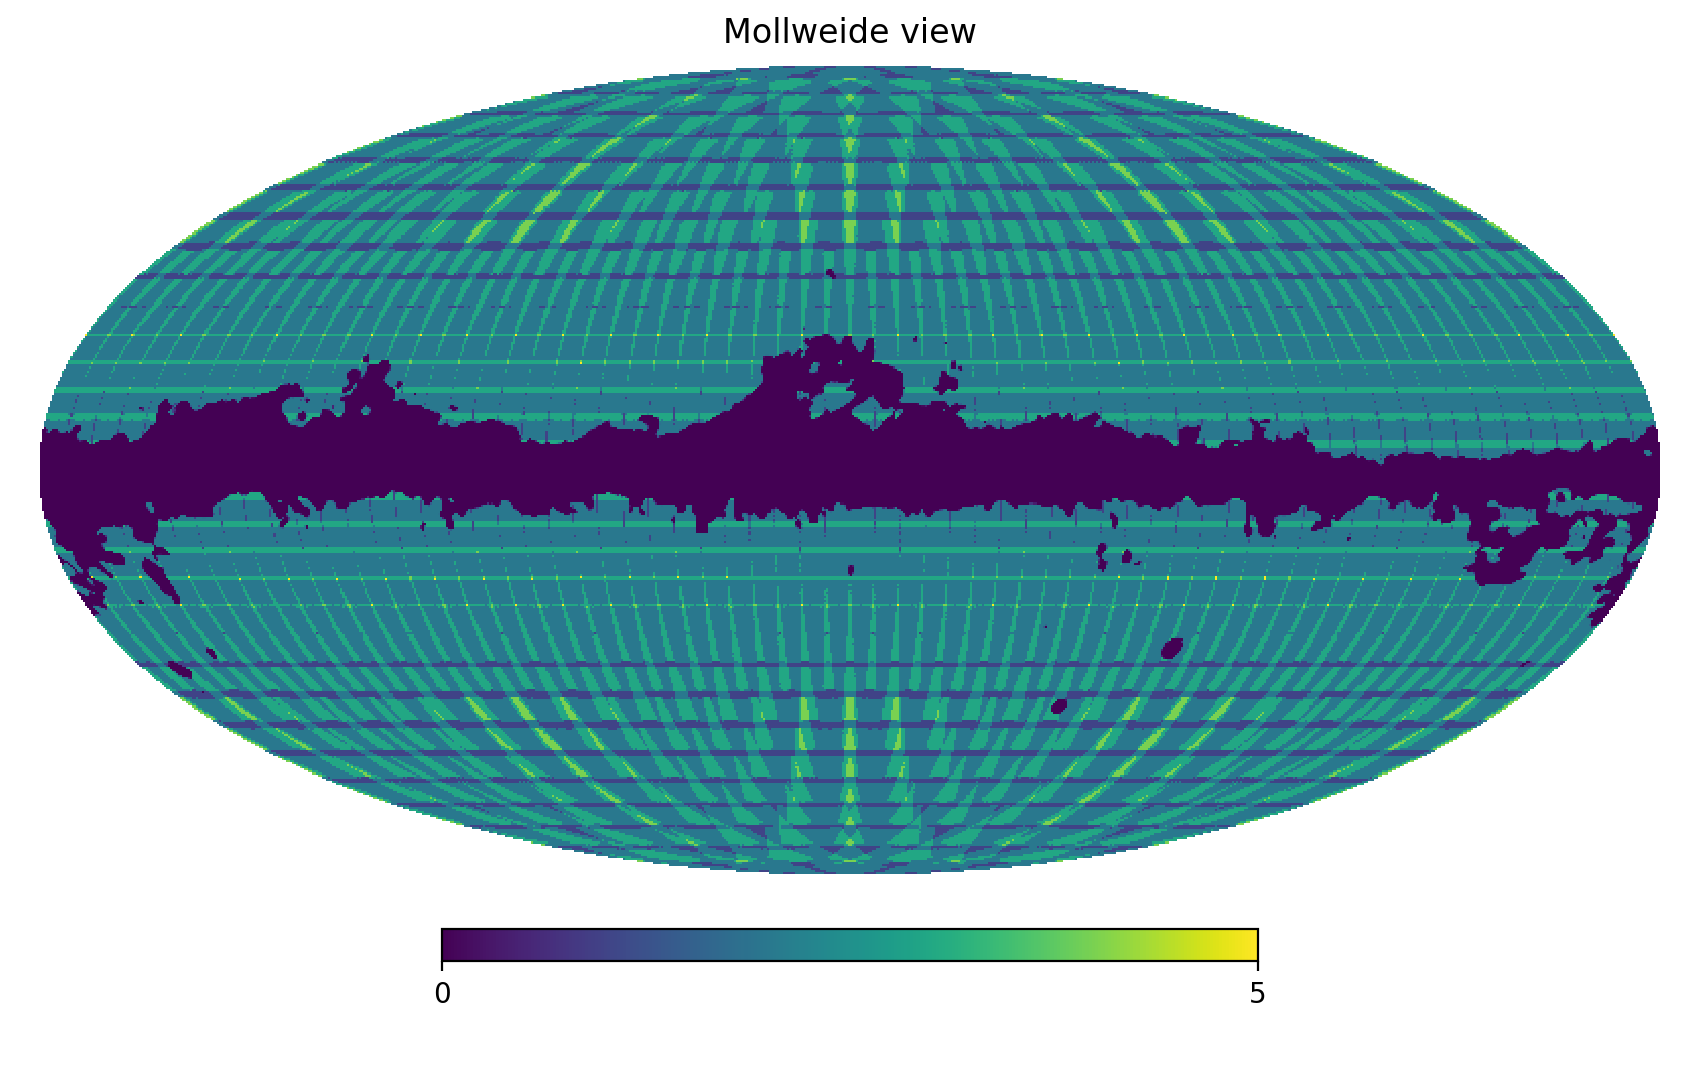

In [4]:
tile_map,fsky_map,apo_mask=tts.return_sky_tile_map()
tiledef=tpd.get_tangent_plane_fnames(fsky_map=fsky_map,fsky_thr=0.3)
h.mollview(tile_map)

In [5]:
# tpd.extract_data_tiles(tiledef)

In [6]:
# def gen_ps_inpainted_data(px):
#     tpd.gen_ps_inpainted_data(px,tiledef)
    
# def parallel_psfill(numprocs):
#     pool=mp.Pool(processes=numprocs)
#     pool.map(gen_ps_inpainted_data,tiledef.keys())
#     pool.close()
#     pool.join()
    
# start=time.time()
# parallel_psfill(4)
# print time.time()-start

In [7]:
tmplt=cltemp.cluster_spectro_spatial_templates(T_step=1.,theta500_min=2.,theta500_max=100.,theta_step=5.)
tmplt.setup_templates()
op=mmf.multi_matched_filter(tmplt.sp_ft_bank,tmplt.sz_spec_bank,tmplt.chfiltr,tmplt.fn_yerr_norm)

<IPython.core.display.Javascript object>


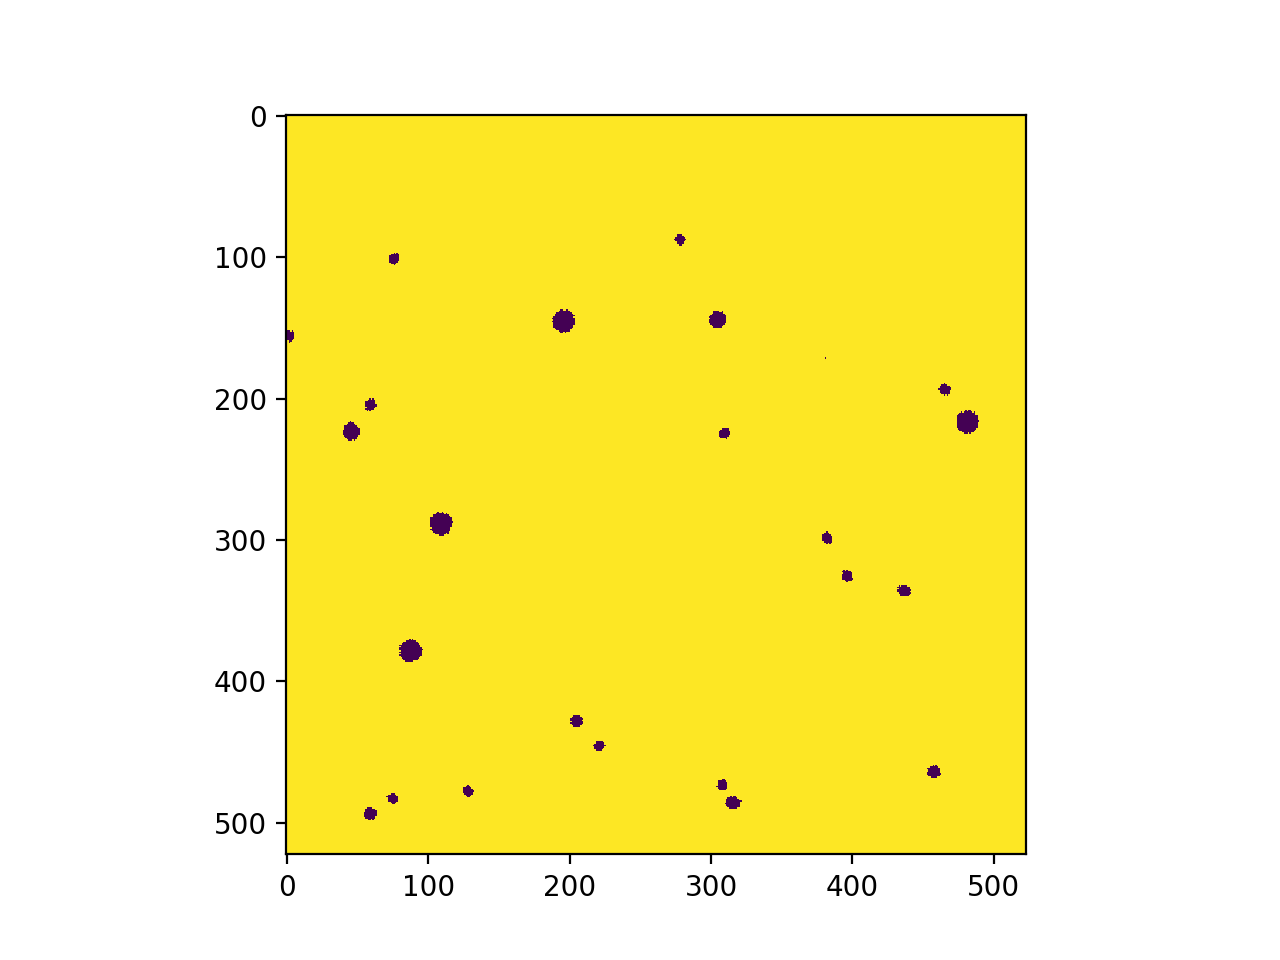

<IPython.core.display.Javascript object>


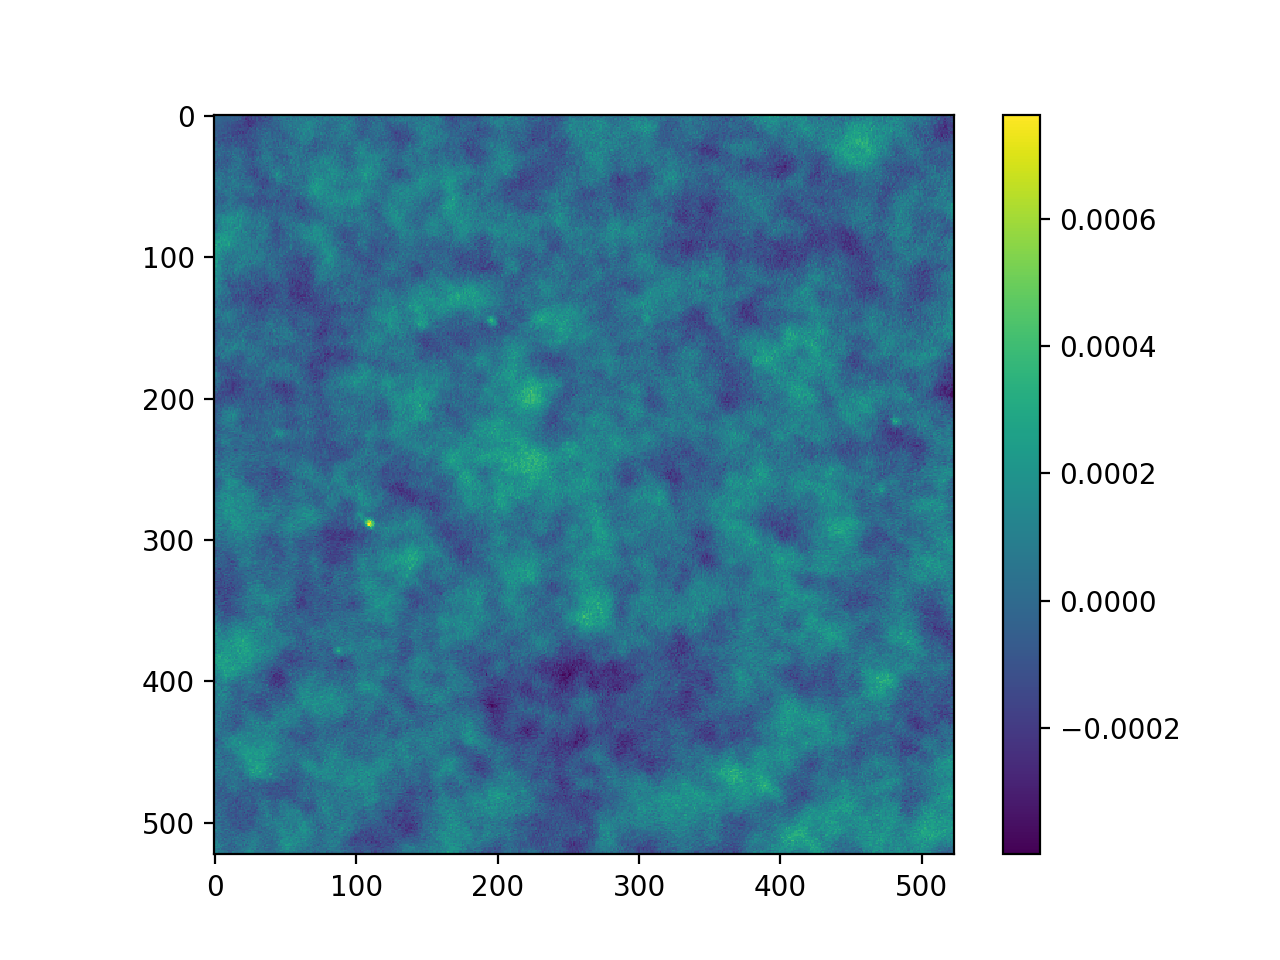

<IPython.core.display.Javascript object>


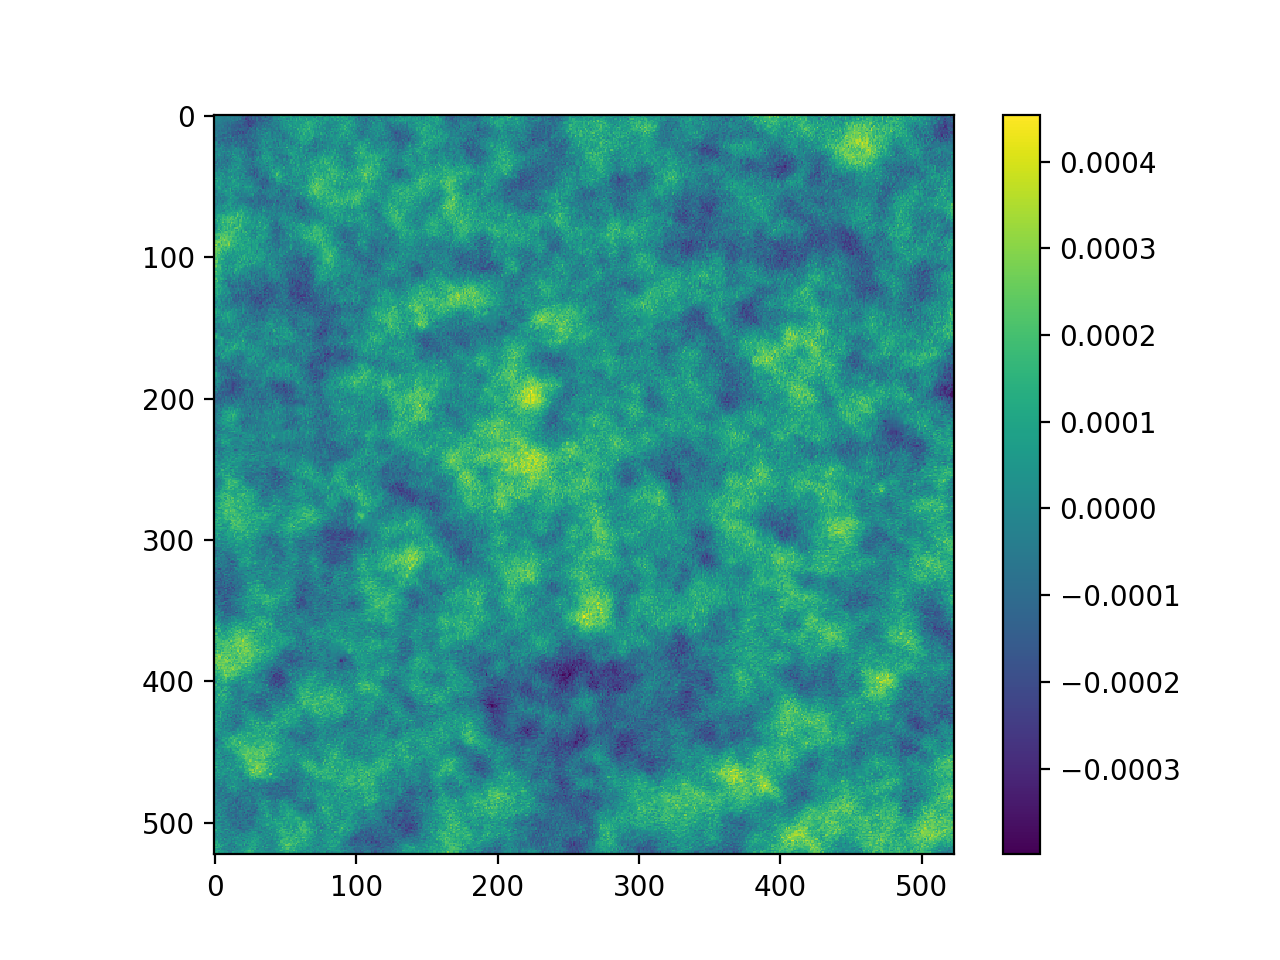

<IPython.core.display.Javascript object>


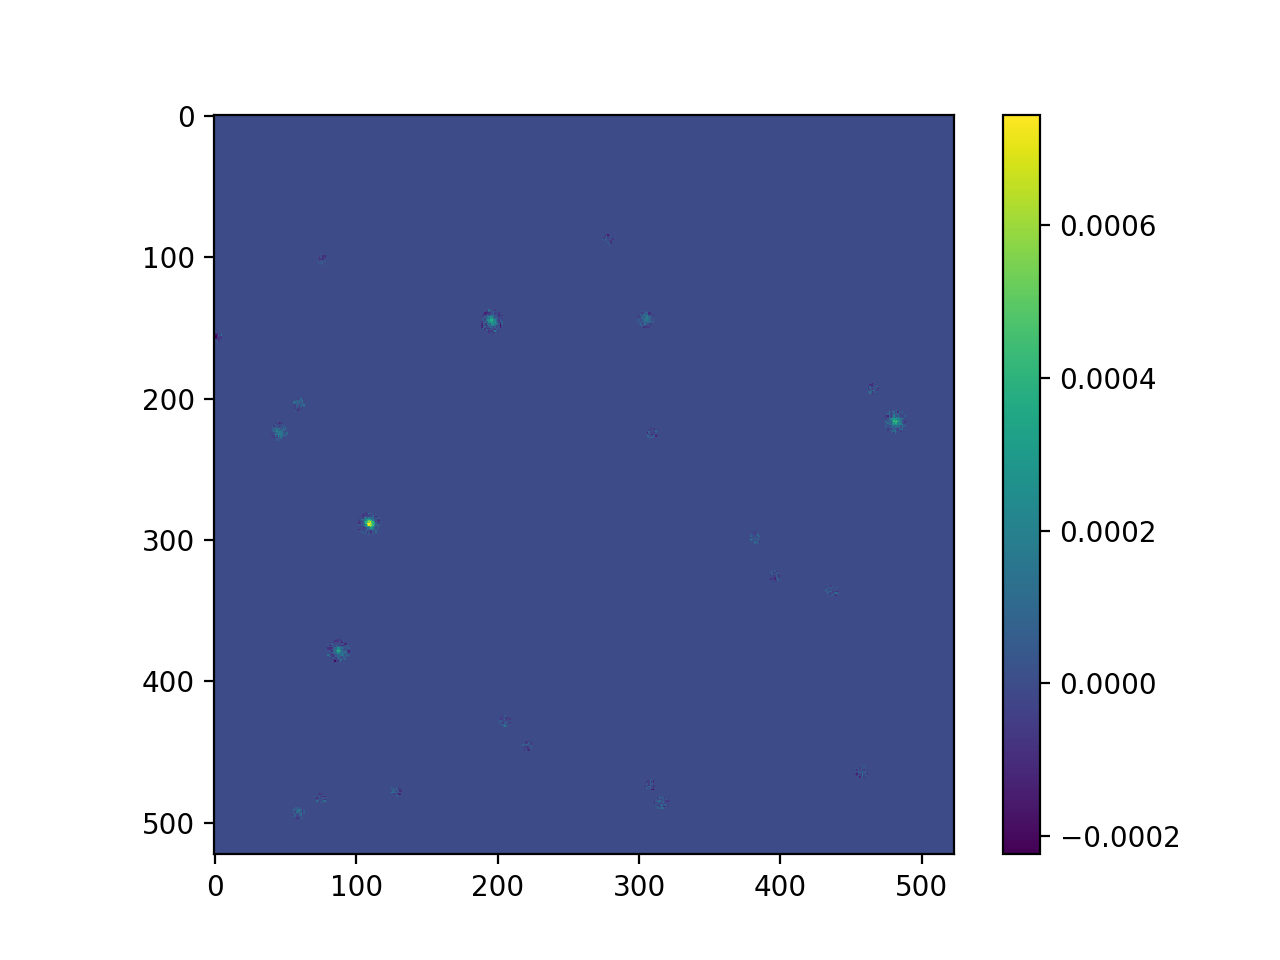

In [8]:
idx=tiledef.keys()[0]
data=fits.getdata(tiledef[idx]["FILENAME"],extname="Data tangent plane")
edata=fits.getdata(tiledef[idx]["FILENAME"],extname="PS inpainted data tangent plane")
gmask=fits.getdata(tiledef[idx]["FILENAME"],extname="Galactic mask")
psmask=fits.getdata(tiledef[idx]["FILENAME"],extname="Point source mask")
figure()
imshow(psmask)

figure()
img=imshow(data[3,]*gmask)
colorbar(img)

figure()
img=imshow(edata[3,]*gmask)
colorbar(img)

figure()
img=imshow(data[3,]*gmask-edata[3,]*gmask)
colorbar(img)

In [179]:
# f=fits.open(cat_def["FILENAME"][1])
# f.info()

# fig, (ax1, ax2,ax3) = plt.subplots(ncols=3)
# img1 = ax1.imshow(f[2].data[5,]*1e6,origin="lower") ; colorbar(img1)
# ax1.axis("off")
# ax1.set_title("Data with PS un-subtracted",fontsize=8)

# img2 = ax2.imshow(f[5].data[5,]*1e6*ext_ps_mask,origin="lower") ; colorbar(img2)
# ax2.axis("off")
# ax2.set_title(r"Point source inpainted data",fontsize=8)


# img3 = ax3.imshow(f[5].data[5,]*1e6,origin="lower") ; colorbar(img3)
# ax3.axis("off")
# ax3.set_title(r"Point source inpainted data",fontsize=8)

# plt.tight_layout(h_pad=1)
# figname=figpath + "example_inpainting.pdf"
# plt.savefig(figname,bbox_inches="tight",dpi=500)
# f.close()

In [9]:
def gen_peak_mask(cart_coord,radius):
    ix,iy=cart_coord
    tmask=np.ones((gset.mmfset.npix,gset.mmfset.npix),float)
    distance=np.zeros((gset.mmfset.npix,gset.mmfset.npix),float)
    x,y=np.indices((distance.shape))
    distance=np.sqrt((x-ix)**2. +(y-iy)**2.)*gset.mmfset.reso
    tmask[distance<=radius]=0
    return tmask

def return_cluster_mask(cart_coord,snrmap,snrthr=4,frac=0.7):
    x,y=cart_coord
    pmask=np.zeros_like(snrmap)
    pmask[x,y]=1.
    step=0
#     while all(snrmap[pmask==1]>=snrthr):
#     print sum((snrmap[pmask==1]>=snrthr)*1.)/len((snrmap[pmask==1]>=snrthr))
    while sum((snrmap[pmask==1]>=snrthr)*1.)/len((snrmap[pmask==1]>=snrthr)) > frac:
        step=step+1
        pmask=1-gen_peak_mask(cart_coord,step*gset.mmfset.reso)
#         print sum((snrmap[pmask==1]>=snrthr)*1.)/len((snrmap[pmask==1]>=snrthr))
    radius=(step-1)*gset.mmfset.reso
    return gen_peak_mask(cart_coord,radius)

def return_distance(gal_coord1,gal_coord2):
    glon1,glat1=gal_coord1
    glon2,glat2=gal_coord2
    theta1=(90.-glat1)*np.pi/180.
    theta2=(90.-glat2)*np.pi/180.
    phi1=glon1*np.pi/180.
    phi2=glon2*np.pi/180.
    cosbeta=np.sin(theta1)*np.sin(theta2)*np.cos(phi2-phi1)+np.cos(theta1)*np.cos(theta2)
    beta=np.arccos(cosbeta)*180.*60./np.pi
    return beta

def return_cartesian_distance(cart_coord1,cart_coord2):
    x1,y1=cart_coord1
    x2,y2=cart_coord2
    beta=np.sqrt((x1-x2)**2. + (y1-y2)**2)*gset.mmfset.reso
    return beta

def myprint(text,verbose):
    if verbose:
        print text

def return_mf_cluster_model(cluscat):
    cmodel=np.zeros((gset.mmfset.npix,gset.mmfset.npix),float)
    multi_freq_cluster_model=np.zeros(data.shape,float)
    for ict in cluscat.keys():
        glon,glat=cluscat[ict]["mp_gal_coord"]
        x,y=projop.ang2ij(glon,glat)
        theta500=cluscat[ict]["mp_thetac"]
        yc=cluscat[ict]["mp_yc"]
        cmodel=cmodel + sc.gen_field_cluster_template(x,y,theta500,yc,gset.mmfset.npix,gset.mmfset.reso)
    cmodel_ft=fsa.map2alm(cmodel,gset.mmfset.reso)
    for i, ch in enumerate(gset.mmfset.channels):
        multi_freq_cluster_model[i,]=fsa.alm2map(cmodel_ft*op.chfiltr[ch]*op.sz_spec_bank[0][ch],gset.mmfset.reso)
    return multi_freq_cluster_model

def return_cluster_cat(data,err,theta500,cluscat,snrthr=4,verbose=False):
    snrthrmask=np.ones_like(data)
    while (max((data*snrthrmask/err).ravel())>snrthr):
        max_snr=max((data*snrthrmask/err).ravel())
        temp_coord=np.where(data*snrthrmask/err == max_snr) 
        x=temp_coord[0][0] ; y=temp_coord[1][0]
        glon,glat=projop.ij2ang(x,y)
        det_cluster={}
        det_cluster["cart_coord"]=(x,y)
        det_cluster["gal_coord"]=(glon,glat)
        det_cluster["yc"]=data[x,y]
        det_cluster["err_yc"]=err
        det_cluster["snr"]=data[x,y]/err
        det_cluster["thetac"]=theta500
        
        nc=[]
        for ict in cluscat.keys():
            dist=return_distance(det_cluster["gal_coord"],cluscat[ict]["gal_coord"])
            #dist=return_cartesian_distance(det_cluster["cart_coord"],cluscat[ict]["cart_coord"])
            nc=nc + [dist<theta500 or dist<cluscat[ict]["thetac"]]
            
        if any(nc):
            myprint("This cluster exists in the catalogue",verbose)
            match_ict=np.where(nc)[0][0]
            if det_cluster["snr"]>cluscat[match_ict]["snr"]:
                myprint("Updating the cluster definition",verbose)
                cluscat[match_ict]=det_cluster
        else:
            myprint("New cluster detected, adding to the cluster catalogue",verbose)
            match_ict=len(cluscat.keys())
            cluscat[match_ict]=det_cluster
        # Here you can define the radius as the size of the cluster of points and that will make it more robust.
        snrthrmask=snrthrmask*gen_peak_mask(det_cluster["cart_coord"],max(5.*det_cluster["thetac"],15.))
        snrthrmask=snrthrmask*return_cluster_mask(det_cluster["cart_coord"],data/err,snrthr=2)
    return cluscat

def return_cluster_cat_new(data,err,theta500,cluscat,snrthr=4,verbose=False):
    snrthrmask=np.ones_like(data)
    Ycyl2YsphR500=szp.convert_Ycyl_xR500_Ysph_xR500(xcyl=tmplt.cutoff,xsph=1.)
    Ycyl2Ysph5R500=szp.convert_Ycyl_xR500_Ysph_xR500(xcyl=tmplt.cutoff,xsph=5.)
    while (max((data*snrthrmask/err).ravel())>snrthr):
        max_snr=max((data*snrthrmask/err).ravel())
        temp_coord=np.where(data*snrthrmask/err == max_snr) 
        x=temp_coord[0][0] ; y=temp_coord[1][0]
        glon,glat=projop.ij2ang(x,y)
        
        det_cluster=collections.OrderedDict()
        det_cluster["yc"]=[data[x,y]]
        det_cluster["err_yc"]=[err]
        det_cluster["snr"]=[data[x,y]/err]
        det_cluster["thetac"]=[theta500]
        det_cluster["cart_coord"]=[(x,y)]
        det_cluster["gal_coord"]=[(glon,glat)]
        det_cluster["YR500"]=[data[x,y]*tmplt.fn_yerr_norm(theta500)*Ycyl2YsphR500]
        det_cluster["err_YR500"]=[err*tmplt.fn_yerr_norm(theta500)*Ycyl2YsphR500]
        det_cluster["Y5R500"]=[data[x,y]*tmplt.fn_yerr_norm(theta500)*Ycyl2Ysph5R500]
        det_cluster["err_Y5R500"]=[err*tmplt.fn_yerr_norm(theta500)*Ycyl2Ysph5R500]
        
        nc=[]
        for ict in cluscat.keys():
            dist=return_distance(det_cluster["gal_coord"][0],cluscat[ict]["mp_gal_coord"])
            #dist=return_cartesian_distance(det_cluster["cart_coord"],cluscat[ict]["cart_coord"])
            nc=nc + [dist<theta500 or dist<cluscat[ict]["mp_thetac"]]
            
        if any(nc):
            myprint("This cluster exists in the catalogue",verbose)
            match_ict=np.where(nc)[0][0]
            for key in det_cluster.keys():
                cluscat[match_ict][key]=cluscat[match_ict][key] + det_cluster[key]
            if det_cluster["snr"][0]>cluscat[match_ict]["mp_snr"]:
                myprint("Updating the cluster definition",verbose)
                for key in det_cluster.keys():
                    cluscat[match_ict]["mp_" + key]=det_cluster[key][0]
        else:
            myprint("New cluster detected, adding to the cluster catalogue",verbose)
            match_ict=len(cluscat.keys())
            cluscat[match_ict]=det_cluster
            for key in det_cluster.keys():
                cluscat[match_ict]["mp_" + key]=det_cluster[key][0]
        # Here you can define the radius as the size of the cluster of points and that will make it more robust.
        snrthrmask=snrthrmask*gen_peak_mask(det_cluster["cart_coord"][0],max(5.*det_cluster["thetac"][0],15.))
        snrthrmask=snrthrmask*return_cluster_mask(det_cluster["cart_coord"][0],data/err,snrthr=4.)
    return cluscat

def gen_tile_figs(data,theta500,err,cluscat,showplt=False):
    if showplt:
        ion()
    else:
        ioff()
    
    fig, ax1 = plt.subplots(ncols=1)
    snrthrmask[:]=1.
    for ict in tile_char["cat"].keys():
        x,y=cluscat[ict]["mp_cart_coord"]
        snr=cluscat[ict]["mp_snr"]
        radius=(snr)*1.5
        circ = Circle((y,x),radius,edgecolor='red', facecolor="none",alpha=0.85,linewidth=0.8)
        ax1.add_patch(circ)
    img1 = ax1.imshow(data/err,vmin=-3,vmax=6.,origin="lower")
    colorbar(img1)
    ax1.set_title("Filtered data SNR [ $\sigma=$"+ str(round(err*1e5,2)) + r"; $\theta_{500}=$" + str(round(theta500)) + "]",fontsize=8)
    cluspath=figpath + tilename + "/" ; ensure_dir(cluspath)
    filename=cluspath + tilename + "_clusdet_iter" + str(ith).zfill(2) + ".jpeg"
    plt.savefig(filename,bbox_inches="tight",dpi=300)
    
    

In [10]:
tile_cluscat={}
idx=tiledef.keys()[0]
filename=tiledef[idx]["FILENAME"]
tilename=tiledef[idx]["TILENAME"]
emask=gm.return_edge_apodized_mask(edge_width=30,fwhm=30)
ps_mask=gtp.return_ps_mask(filename)
ext_ps_mask=gtp.return_ext_ps_mask(filename)
data=gtp.return_data(filename)
glat=tiledef[idx]["GLAT"]
glon=tiledef[idx]["GLON"]
projop=tpa.tangent_plane_setup(gset.mmfset.nside,gset.mmfset.xsize,glat,glon,rescale=1.)
snrthrmask=np.ones_like(emask)
gmask=fits.getdata(filename,extname="Galactic mask")
gmask=emask*ext_ps_mask*gmask

You want to use PSF data, so no masking


In [51]:
# verbose=False
# cluscat={}
# for ith,theta500 in enumerate([55,40.,30.,20, 10., 5., 2.]):
#     op.get_data_ft((data)*emask*ps_mask)
#     fdata,err,snr,yc=op.return_snr(theta500,0.,mask_fdata=False)
    
#     snrthrmask[:]=1.
#     while(max((fdata*snrthrmask*gmask/err).ravel())>4.):
#         max_snr=max((fdata*snrthrmask*gmask/err).ravel())
#         x,y=np.where(fdata*snrthrmask*gmask/err == max_snr)
#         glon,glat=projop.ij2ang(x,y)
#         nx,ny=projop.ang2ij(glon,glat)
#         det_cluster=np.array([glon,glat,fdata[x,y][0],err,theta500])

#         nc=[]
#     #     print len(cluscat.keys())
#         for ict in cluscat.keys():
#             glon1=cluscat[ict][0]
#             glat1=cluscat[ict][1]
#             thetac=cluscat[ict][4]
#             dist=return_distance(glon,glat,glon1,glat1)
#             nc=nc + [dist<theta500 or dist<thetac]
          
#         # This was being tried as an attempt to not have to calculate the distance between all cluster pairs.
#         # But if the cluster matches, then we need to know which cluster matches, so as to update the characteristics
#         # If needed.
# #         nc=[False] ; ict=0
# #         max_cl=len(cluscat.keys())
# #     #     print len(cluscat.keys())
# #         while not(any(nc)) and ict<max_cl-1:
# #             glon1=cluscat[ict][0]
# #             glat1=cluscat[ict][1]
# #             thetac=cluscat[ict][4]
# #             dist=return_distance(glon,glat,glon1,glat1)
# #             nc=nc + [dist<theta500 or dist<thetac]

#         if any(nc):
#             myprint("This cluster exists in the catalogue",verbose)
#             match_ict=np.where(nc)[0][0]
#             snr_new=det_cluster[2]/det_cluster[3]
#             snr_old=cluscat[match_ict][2]/cluscat[match_ict][3]
#             if snr_new>snr_old:
#                 myprint("Updating the cluster definition",verbose)
# #                 print snr_new,snr_old,det_cluster[4],cluscat[match_ict][4]
#                 cluscat[match_ict]=det_cluster
#         else:
#             myprint("New cluster detected, adding to the cluster catalogue",verbose)
#             max_ict=len(cluscat.keys())
#             cluscat[max_ict]=det_cluster
#         # Here you can define the radius as the size of the cluster of points and that will make it more robust.
#         snrthrmask=snrthrmask*gen_peak_mask(x,y,max(5.*theta500,15.))
#         snrthrmask=snrthrmask*return_cluster_mask(x,y,fdata*gmask/err,snrthr=2)
# #     print cluscat
#     fig, ax1 = plt.subplots(ncols=1)
#     snrthrmask[:]=1.
#     for ict in cluscat.keys():
#         glon=cluscat[ict][0]
#         glat=cluscat[ict][1]
#         x,y=projop.ang2ij(glon,glat)
#         snr=cluscat[ict][2]/cluscat[ict][3]
#         radius=(snr)*1.5
#         circ = Circle((y,x),radius,edgecolor='red', facecolor="none",alpha=0.85,linewidth=0.8)
#         ax1.add_patch(circ)
#     img1 = ax1.imshow(fdata*gmask/err,vmin=-2,vmax=6,origin="lower")
#     colorbar(img1)
#     ax1.set_title("Filtered data SNR [ $\sigma=$"+ str(round(err*1e5,2)) + r"; $\theta_{500}=$" + str(round(theta500)) + "]",fontsize=8)
#     cluspath=figpath + tilename + "/" ; ensure_dir(cluspath)
#     filename=cluspath + tilename + "_clusdet_iter" + str(ith).zfill(2) + ".jpeg"
#     savefig(filename,bbox_inches="tight",dpi=300)
# tile_cluscat[tilename]=cluscat

In [52]:
# verbose=False
# cluscat={}
# for ith,theta500 in enumerate([55,40.,30.,20, 10., 5., 2.]):
#     op.get_data_ft((data)*emask*ps_mask)
#     fdata,err,snr,yc=op.return_snr(theta500,0.,mask_fdata=False)
    
#     snrthrmask[:]=1.
#     while(max((fdata*snrthrmask*gmask/err).ravel())>4.):
#         max_snr=max((fdata*snrthrmask*gmask/err).ravel())
#         x,y=np.where(fdata*snrthrmask*gmask/err == max_snr)
#         glon,glat=projop.ij2ang(x,y)
#         nx,ny=projop.ang2ij(glon,glat)
#         det_cluster={}
#         det_cluster["cart_coord"]=(x,y)
#         det_cluster["gal_coord"]=(glon,glat)
#         det_cluster["yc"]=fdata[x,y][0]
#         det_cluster["err_yc"]=err
#         det_cluster["snr"]=fdata[x,y][0]/err
#         det_cluster["thetac"]=theta500
#         #det_cluster=np.array([glon,glat,fdata[x,y][0],err,theta500])

#         nc=[]
#     #     print len(cluscat.keys())
#         for ict in cluscat.keys():
#             dist=return_distance(det_cluster["gal_coord"],cluscat[ict]["gal_coord"])
# #             cdist=return_cartesian_distance(det_cluster["cart_coord"],cluscat[ict]["cart_coord"])
# #             print dist,cdist
#             nc=nc + [dist<theta500 or dist<cluscat[ict]["thetac"]]
          
#         # This was being tried as an attempt to not have to calculate the distance between all cluster pairs.
#         # But if the cluster matches, then we need to know which cluster matches, so as to update the characteristics
#         # If needed.
# #         nc=[False] ; ict=0
# #         max_cl=len(cluscat.keys())
# #     #     print len(cluscat.keys())
# #         while not(any(nc)) and ict<max_cl-1:
# #             glon1=cluscat[ict][0]
# #             glat1=cluscat[ict][1]
# #             thetac=cluscat[ict][4]
# #             dist=return_distance(glon,glat,glon1,glat1)
# #             nc=nc + [dist<theta500 or dist<thetac]

#         if any(nc):
#             myprint("This cluster exists in the catalogue",verbose)
#             match_ict=np.where(nc)[0][0]
#             snr_new=det_cluster["snr"]
#             snr_old=cluscat[match_ict]["snr"]
#             if snr_new>snr_old:
#                 myprint("Updating the cluster definition",verbose)
# #                 print snr_new,snr_old,det_cluster[4],cluscat[match_ict][4]
#                 cluscat[match_ict]=det_cluster
#         else:
#             myprint("New cluster detected, adding to the cluster catalogue",verbose)
#             max_ict=len(cluscat.keys())
#             cluscat[max_ict]=det_cluster
#         # Here you can define the radius as the size of the cluster of points and that will make it more robust.
#         snrthrmask=snrthrmask*gen_peak_mask(det_cluster["cart_coord"],max(5.*theta500,15.))
#         snrthrmask=snrthrmask*return_cluster_mask(det_cluster["cart_coord"],fdata*gmask/err,snrthr=2)
# #     print cluscat
#     fig, ax1 = plt.subplots(ncols=1)
#     snrthrmask[:]=1.
#     for ict in cluscat.keys():
#         x,y=cluscat[ict]["cart_coord"]
#         snr=cluscat[ict]["snr"]
#         radius=(snr)*1.5
#         circ = Circle((y,x),radius,edgecolor='red', facecolor="none",alpha=0.85,linewidth=0.8)
#         ax1.add_patch(circ)
#     img1 = ax1.imshow(fdata*gmask/err,vmin=-2,vmax=6,origin="lower")
#     colorbar(img1)
#     ax1.set_title("Filtered data SNR [ $\sigma=$"+ str(round(err*1e5,2)) + r"; $\theta_{500}=$" + str(round(theta500)) + "]",fontsize=8)
#     cluspath=figpath + tilename + "/" ; ensure_dir(cluspath)
#     filename=cluspath + tilename + "_clusdet_iter" + str(ith).zfill(2) + ".jpeg"
#     savefig(filename,bbox_inches="tight",dpi=300)
# tile_cluscat[tilename]=cluscat

In [17]:
tile_cluscat={}
idx=tiledef.keys()[0]
filename=tiledef[idx]["FILENAME"]
tilename=tiledef[idx]["TILENAME"]
emask=gm.return_edge_apodized_mask(edge_width=30,fwhm=30)
ps_mask=gtp.return_ps_mask(filename)
ext_ps_mask=gtp.return_ext_ps_mask(filename)
data=gtp.return_data(filename)
glat=tiledef[idx]["GLAT"]
glon=tiledef[idx]["GLON"]
projop=tpa.tangent_plane_setup(gset.mmfset.nside,gset.mmfset.xsize,glat,glon,rescale=1.)
snrthrmask=np.ones_like(emask)
galmask=fits.getdata(filename,extname="Galactic mask")
gmask=emask*ext_ps_mask*galmask

You want to use PSF data, so no masking


<IPython.core.display.Javascript object>


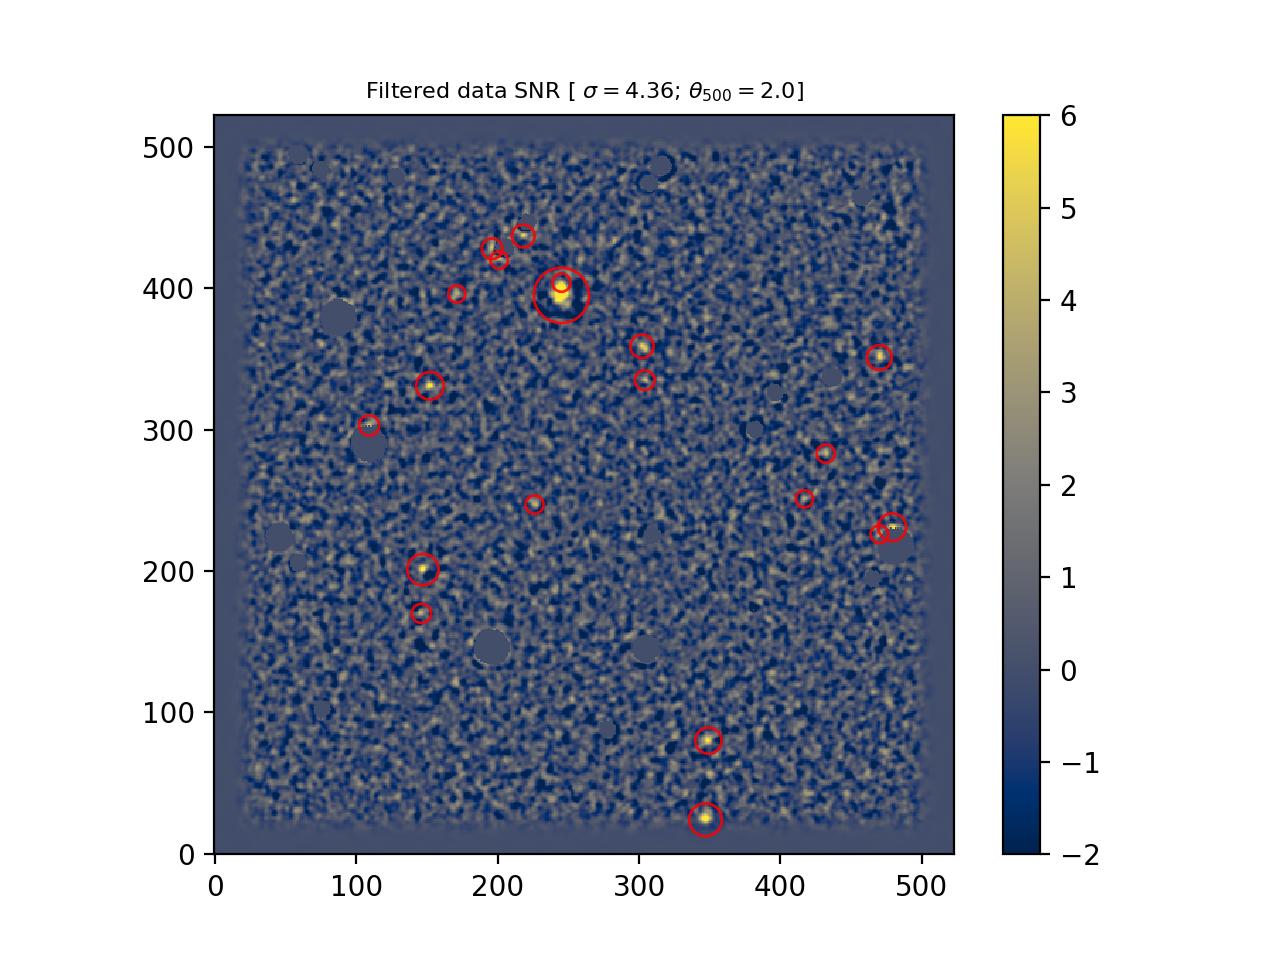

<IPython.core.display.Javascript object>


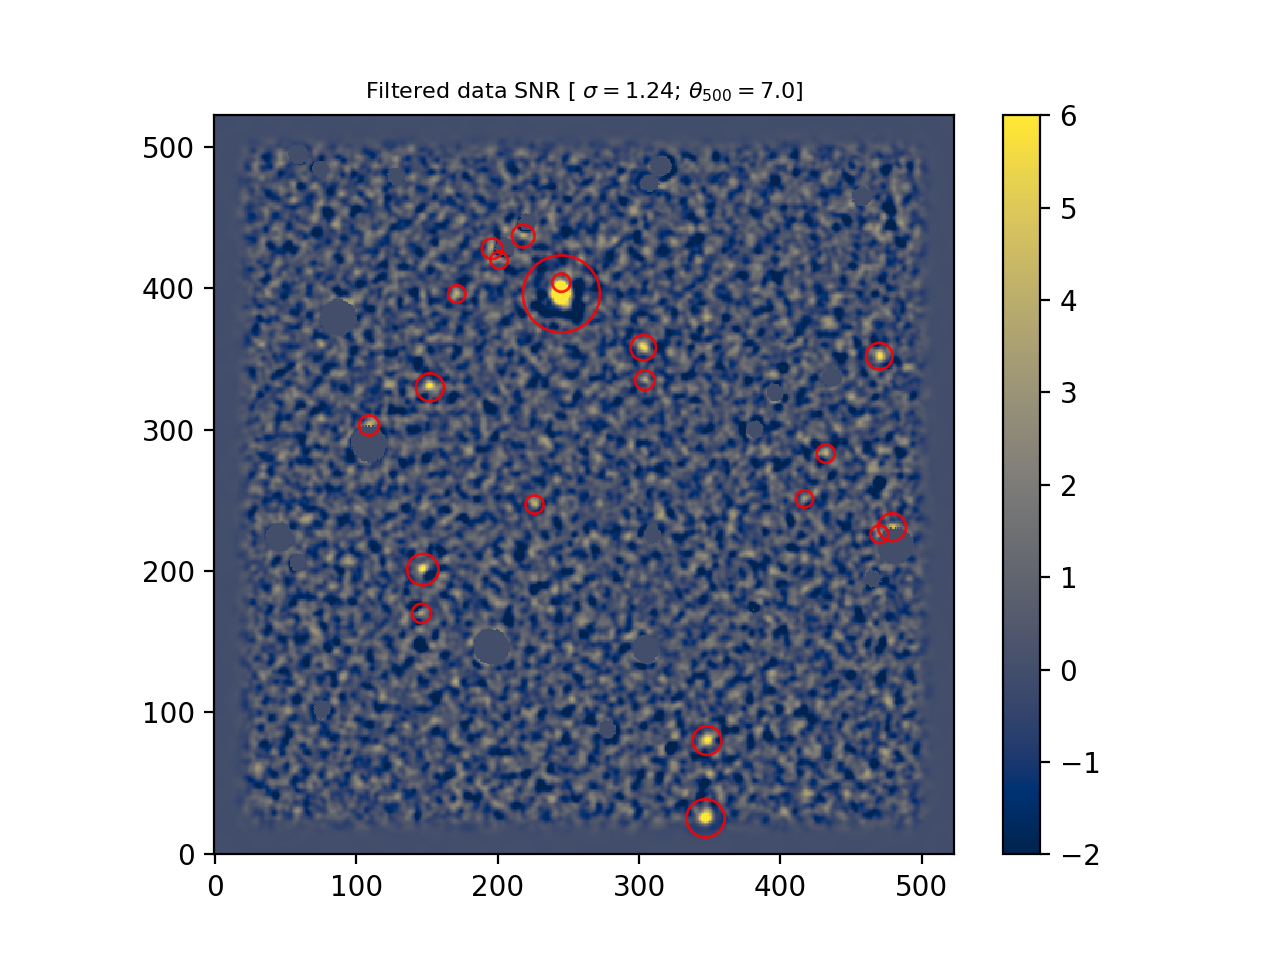

In [88]:
verbose=False
tile_char=collections.OrderedDict()
tile_char["pix"]=idx
tile_char["theta500"]=np.array([])
tile_char["err_Y500"]=np.array([])
tile_char["cat"]={}
Ycyl2Ysph=szp.convert_Ycyl_xR500_Ysph_xR500(xcyl=tmplt.cutoff,xsph=1)
# for ith,theta500 in enumerate(tmplt.theta500[::-1]):
for ith,theta500 in enumerate(tmplt.theta500[:2]):
    op.get_data_ft((data*gmask)*emask*ps_mask)
    fdata,err,snr,yc=op.return_snr(theta500,0.,mask_fdata=False)
    fsky=np.sum(galmask)/size(galmask) ; tile_char["fsky"]=fsky
    err=err/np.sqrt(fsky)
    tile_char["theta500"]=np.append(tile_char["theta500"],theta500)
    tile_char["err_Y500"]=np.append(tile_char["err_Y500"],err*tmplt.fn_yerr_norm(theta500)*Ycyl2Ysph)
    tile_char["cat"]=return_cluster_cat_new(fdata*gmask,err,theta500,tile_char["cat"],snrthr=4.,verbose=False)
    
#     gen_tile_figs(fdata,theta500,err,tile_char["cat"],showplt=False)
    
    fig, ax1 = plt.subplots(ncols=1)
    snrthrmask[:]=1.
    for ict in tile_char["cat"].keys():
        x,y=tile_char["cat"][ict]["mp_cart_coord"]
        snr=tile_char["cat"][ict]["mp_snr"]
        radius=(snr)*1.5
        circ = Circle((y,x),radius,edgecolor='red', facecolor="none",alpha=0.85,linewidth=1.)
        ax1.add_patch(circ)
    img1 = ax1.imshow(fdata*gmask/err,vmin=-2,vmax=6,origin="lower",cmap="cividis")
    colorbar(img1)
    ax1.set_title("Filtered data SNR [ $\sigma=$"+ str(round(err*1e5,2)) + r"; $\theta_{500}=$" + str(round(theta500)) + "]",fontsize=8)
    cluspath=figpath + tilename + "/" ; ensure_dir(cluspath)
    filename=cluspath + tilename + "_clusdet_iter" + str(ith).zfill(2) + ".jpeg"
    savefig(filename,bbox_inches="tight",dpi=300)
    
# This can be read from the dictionaries
tile_cluscat[tilename]=tile_char["cat"]

<IPython.core.display.Javascript object>


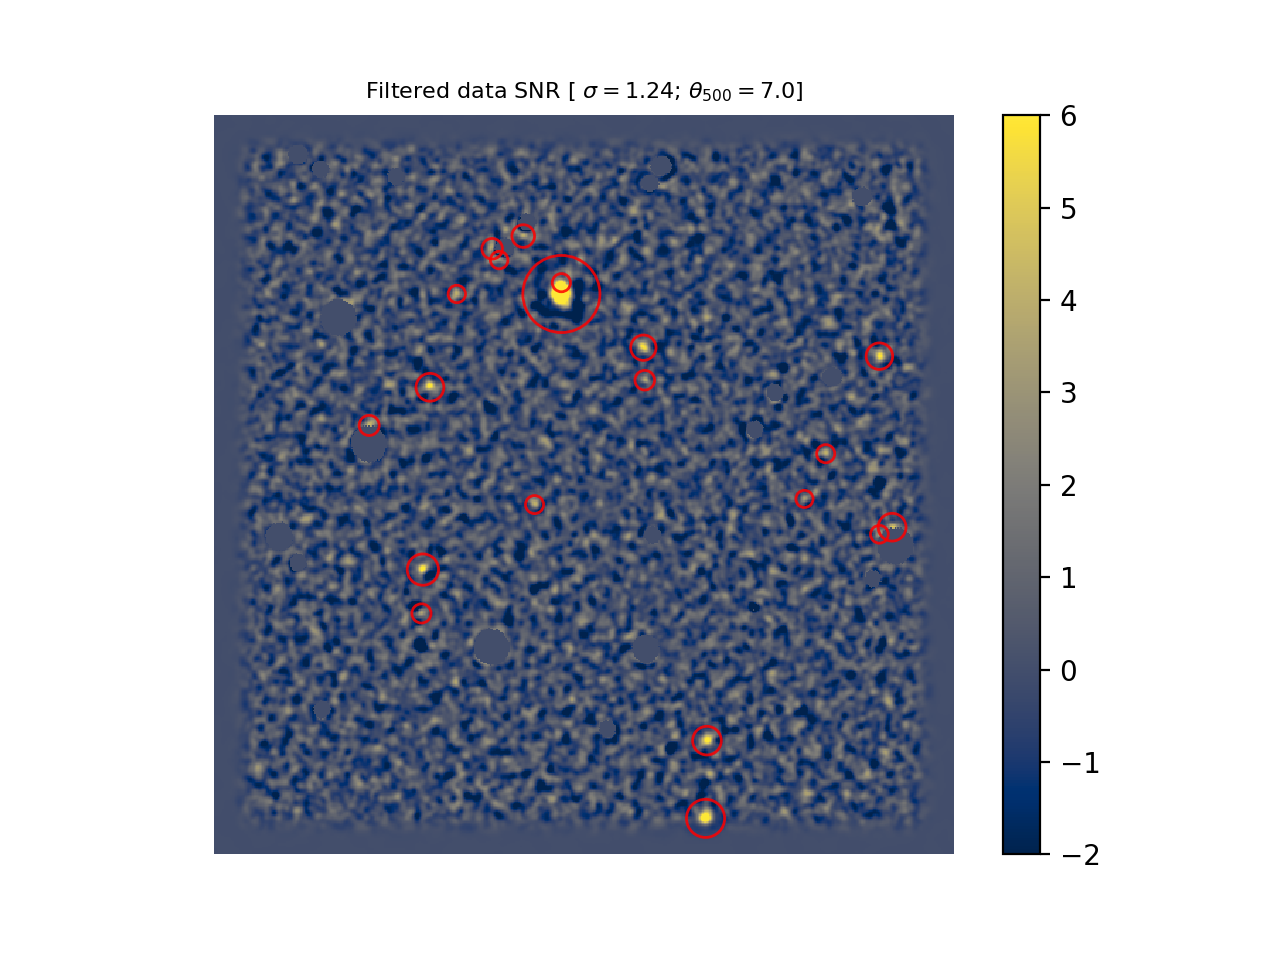

In [91]:
fig, ax1 = plt.subplots(ncols=1)
snrthrmask[:]=1.
ang_dist=gset.mmfset.npix*gset.mmfset.reso/2.
extend=[]
for ict in tile_char["cat"].keys():
    x,y=tile_char["cat"][ict]["mp_cart_coord"]
    snr=tile_char["cat"][ict]["mp_snr"]
    radius=(snr)*1.5
    circ = Circle((y,x),radius,edgecolor='red', facecolor="none",alpha=0.85,linewidth=1.)
    ax1.add_patch(circ)
img1 = ax1.imshow(fdata*gmask/err,vmin=-2,vmax=6,origin="lower",cmap="cividis")
colorbar(img1)
ax1.axis("off")
ax1.set_title("Filtered data SNR [ $\sigma=$"+ str(round(err*1e5,2)) + r"; $\theta_{500}=$" + str(round(theta500)) + "]",fontsize=8)
cluspath=figpath + tilename + "/" ; ensure_dir(cluspath)
filename=cluspath + tilename + "_clusdet_iter" + str(ith).zfill(2) + ".jpeg"
savefig(filename,bbox_inches="tight",dpi=300)

In [87]:
figure()
x=(fdata*emask*ext_ps_mask/err)
x=x.astype("float")
img=imshow(x,vmax=6.0,vmin=-2.0,origin="lower",cmap="turbo")
colorbar(img)

<IPython.core.display.Javascript object>

ValueError: Colormap turbo is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

In [54]:
fdata.dtype

dtype('float64')

<IPython.core.display.Javascript object>


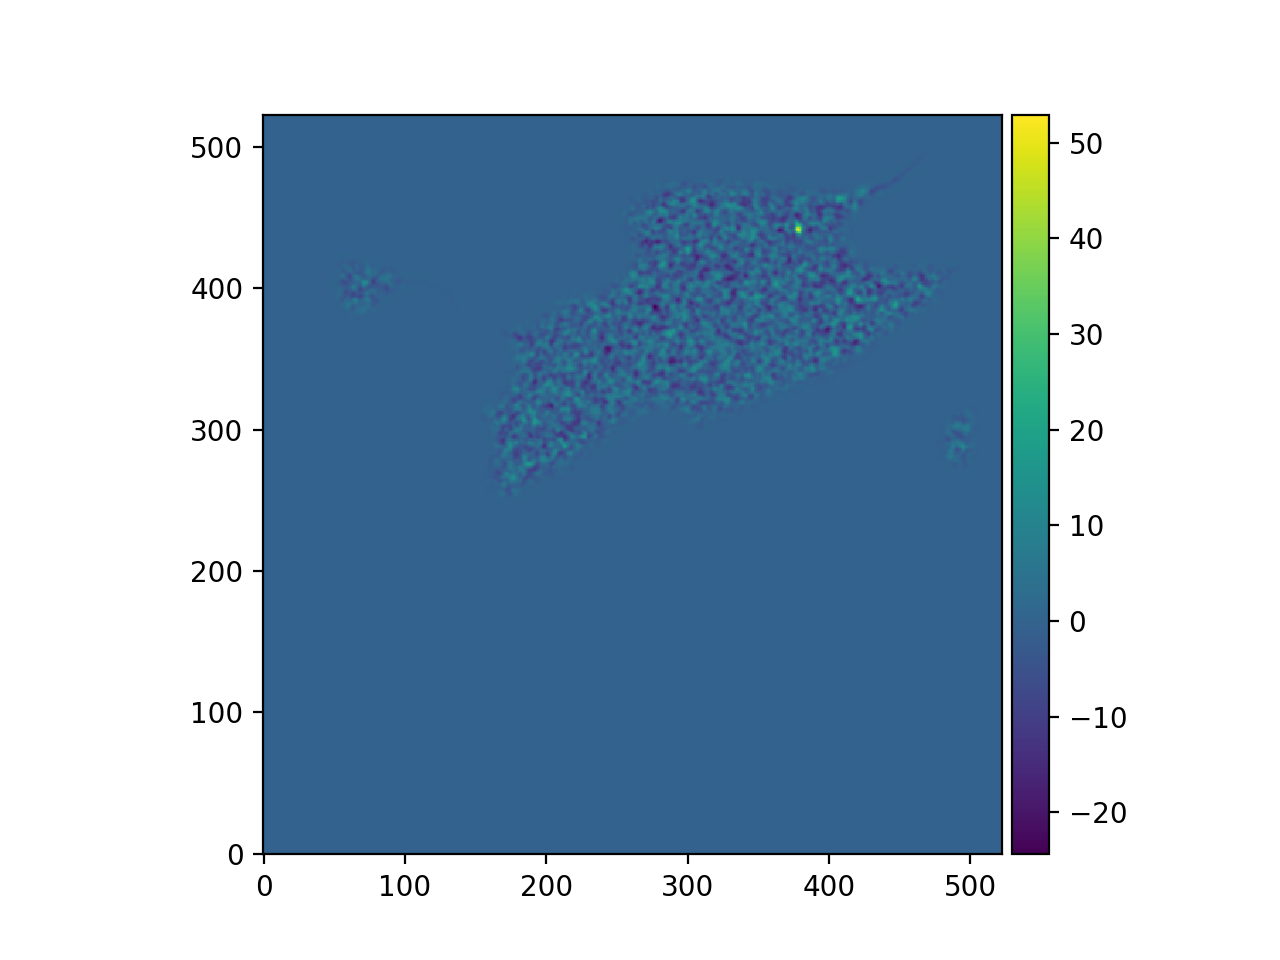

In [85]:
ion()
figure()
img=imshow(fdata*gmask*emask*1,origin="lower")
colorbar(img)

In [99]:
tile_char["cat"][0].keys()

['mp_Y5R500',
 'mp_yc',
 'mp_err_yc',
 'mp_err_YR500',
 'yc',
 'YR500',
 'mp_gal_coord',
 'mp_err_Y5R500',
 'err_Y5R500',
 'thetac',
 'cart_coord',
 'Y5R500',
 'snr',
 'mp_cart_coord',
 'err_YR500',
 'mp_YR500',
 'gal_coord',
 'mp_thetac',
 'err_yc',
 'mp_snr']

<IPython.core.display.Javascript object>


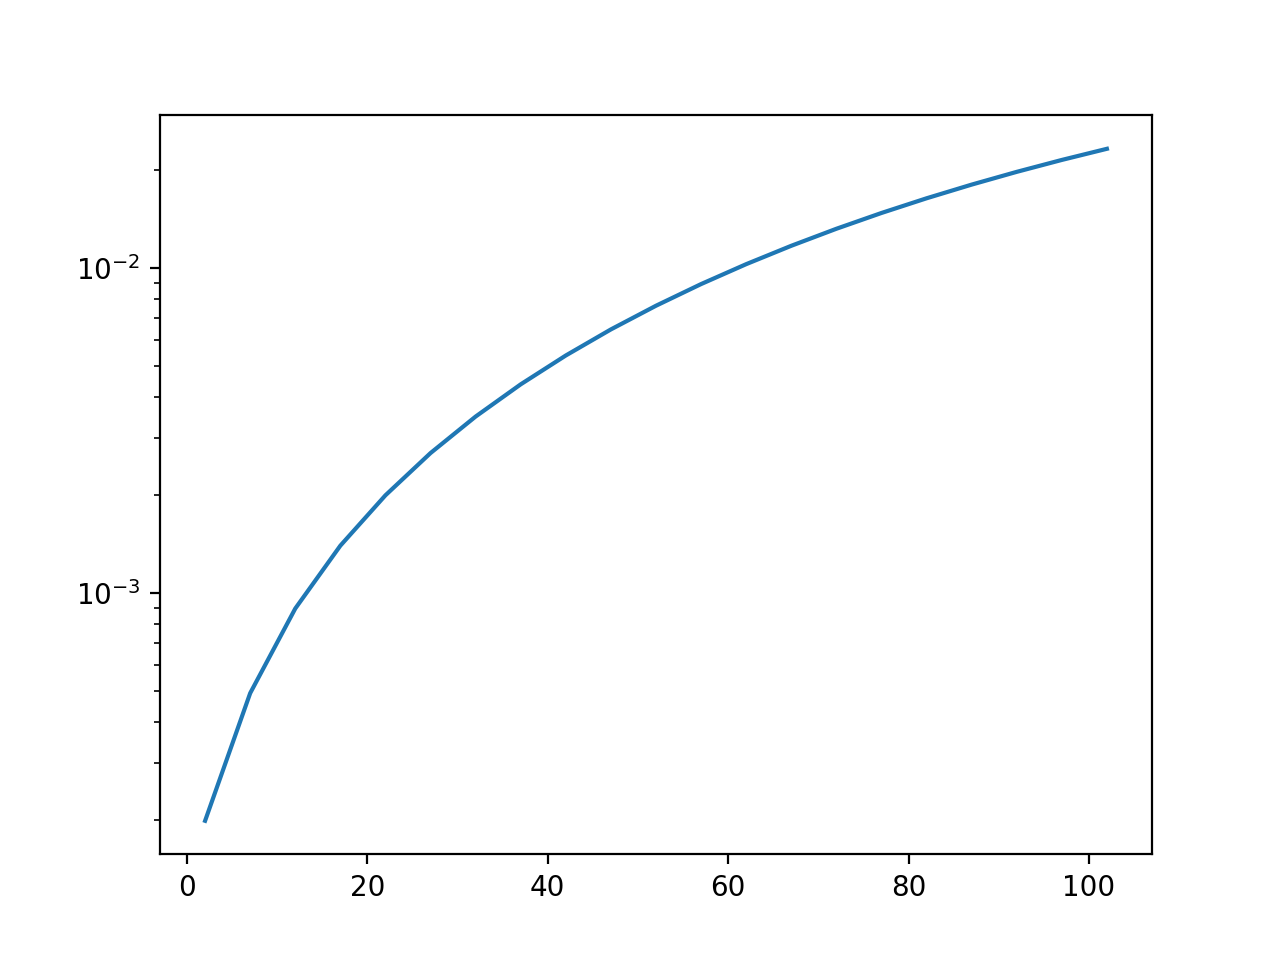

[]

In [36]:
figure()
plot(tile_char["theta500"],tile_char["err_Y500"])
semilogy()

<IPython.core.display.Javascript object>


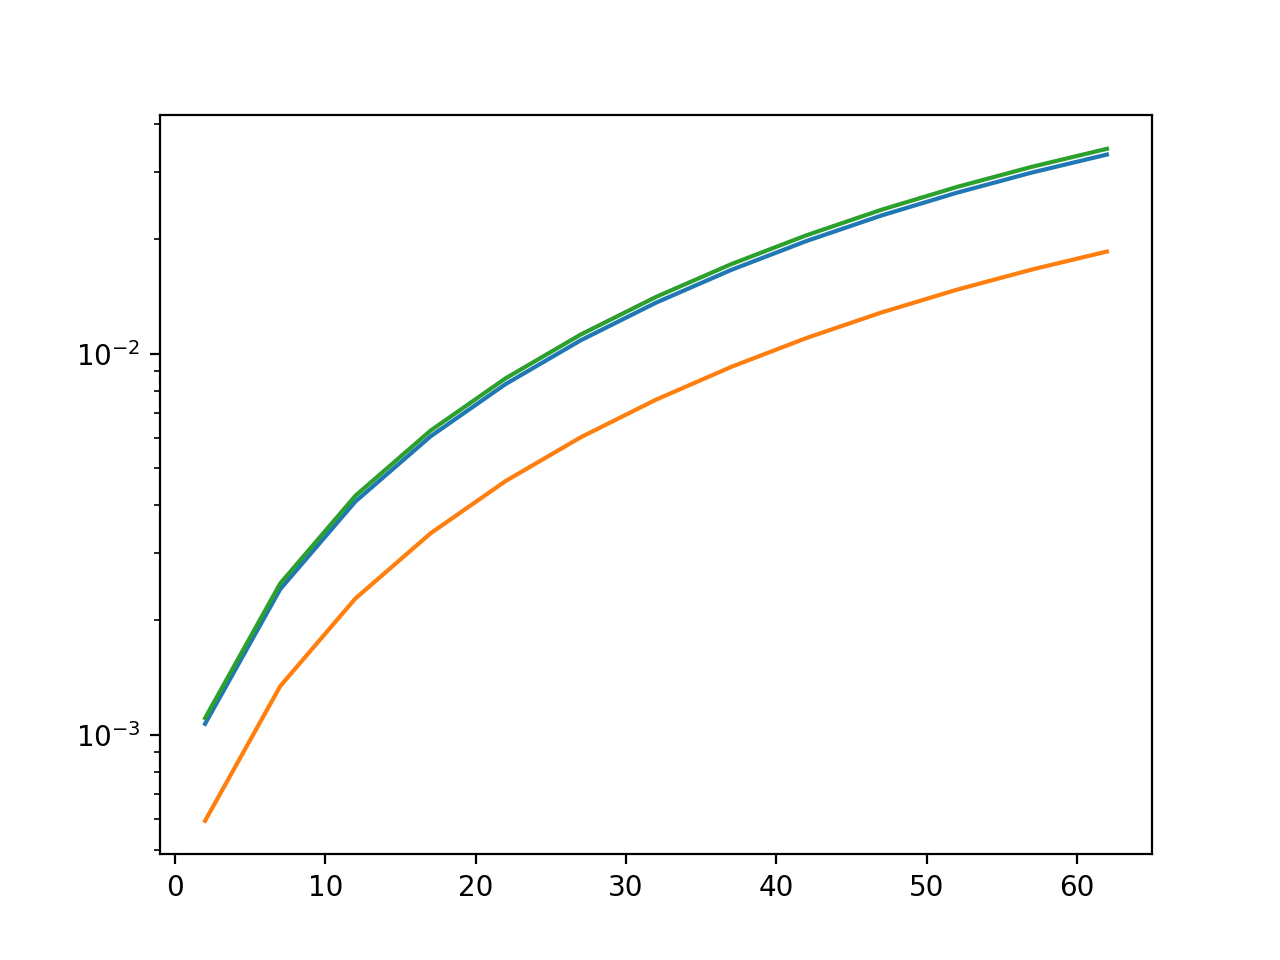

<IPython.core.display.Javascript object>


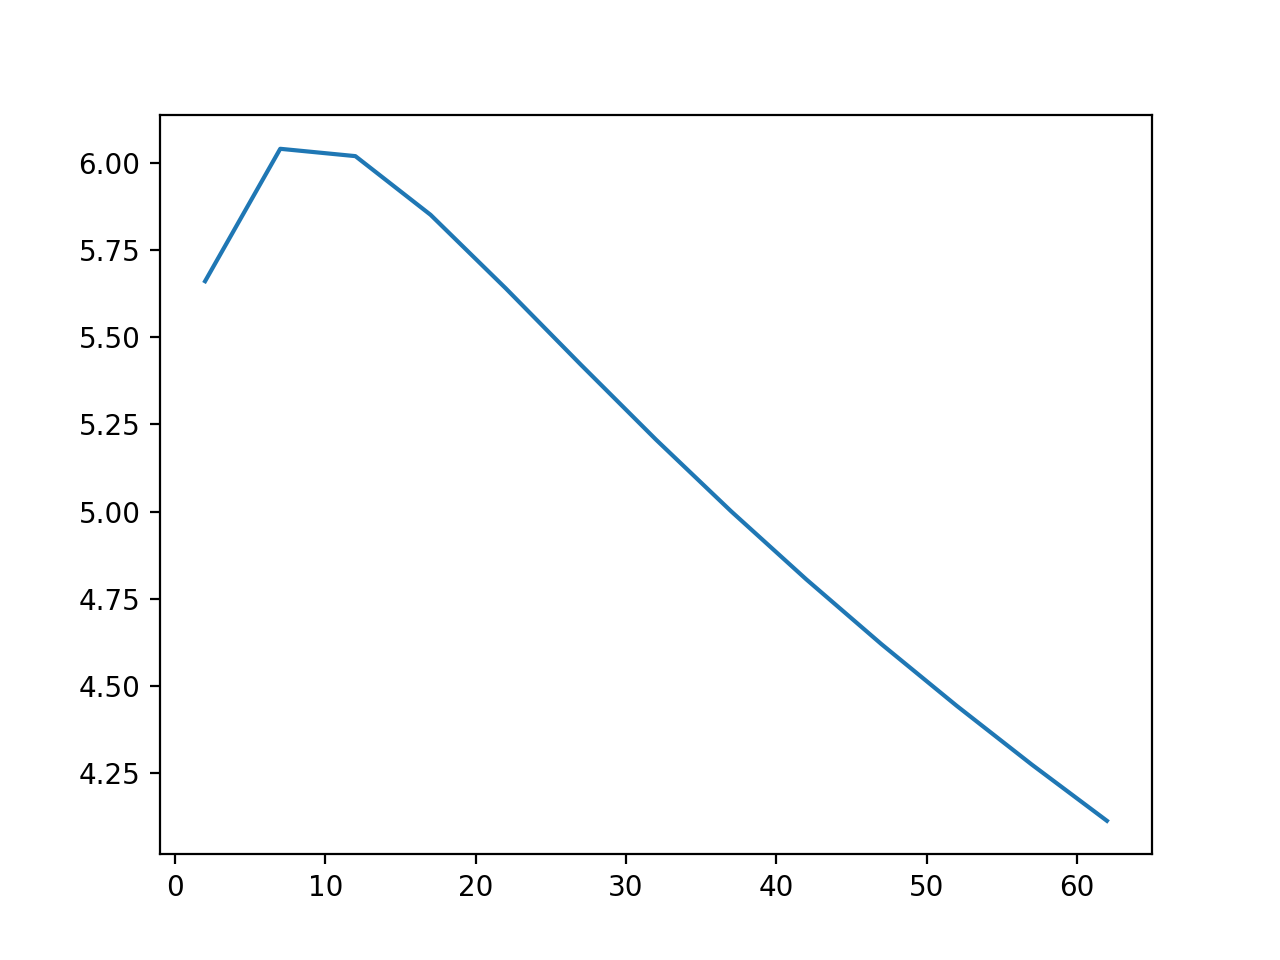

In [281]:
idx=2
figure()
plot(tile_char["cat"][idx]["thetac"],tile_char["cat"][idx]["Y5R500"])
plot(tile_char["cat"][idx]["thetac"],tile_char["cat"][idx]["YR500"])
plot(tile_char["cat"][idx]["thetac"],tile_char["cat"][idx]["yc"]*tmplt.fn_yerr_norm(np.array(tile_char["cat"][idx]["thetac"])))
semilogy()

figure()
plot(tile_char["cat"][idx]["thetac"],tile_char["cat"][idx]["snr"])

In [268]:
tile_char["cat"][idx]["YR500"]

[0.0038795692847512658,
 0.0025837985772428186,
 0.001489966045589177,
 0.0006376662575764857]

<IPython.core.display.Javascript object>


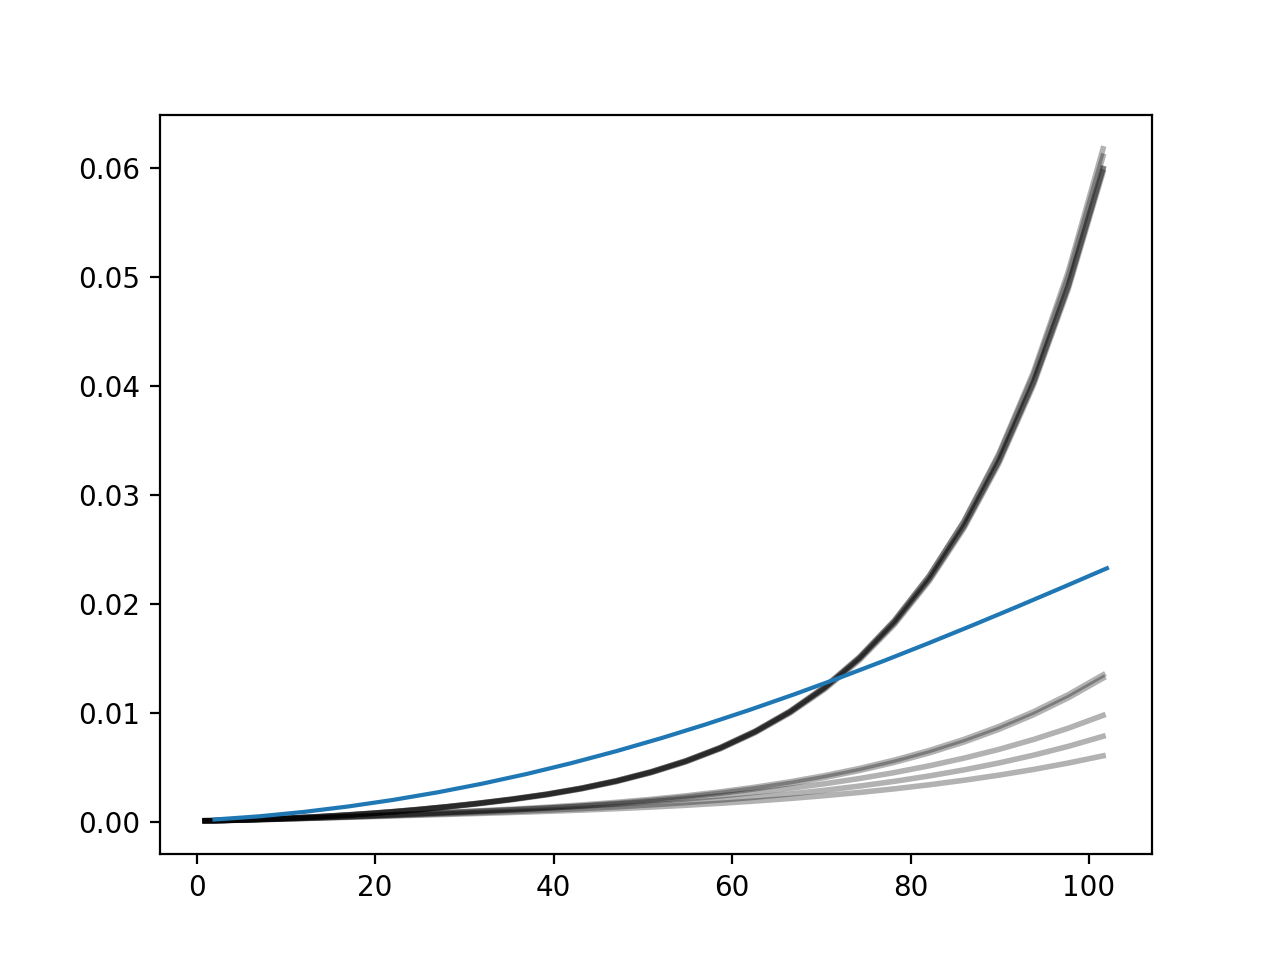

In [39]:
skyfracs=loadtxt("../../../../../../Data/Planck/COM_PCCS_SZ-Catalogs_vPR2/SZ_skyfracs.txt")
ylims=loadtxt("../../../../../../Data/Planck/COM_PCCS_SZ-Catalogs_vPR2/SZ_ylims.txt")
thetas=loadtxt("../../../../../../Data/Planck/COM_PCCS_SZ-Catalogs_vPR2/SZ_thetas.txt")

sig=np.zeros((np.size(skyfracs),np.size(thetas)),float)
cnt_patch=1
cnt_thetas=1
for i in range(np.size(ylims)):
    sig[cnt_patch-1,cnt_thetas-1]=ylims[i]
    cnt_patch=cnt_patch+1
    if cnt_patch>np.size(skyfracs):
        cnt_patch=1
        cnt_thetas=cnt_thetas+1
        
figure()
# for i in range(np.size(skyfracs)):
for i in range(10):
    if i==0:
        plot(thetas,sig[i,:],"k-",lw=2,alpha=0.3,label="Planck MMF3 (is it MMF3?)")
    else:
        plot(thetas,sig[i,:],"k-",lw=2,alpha=0.3)
plot(tile_char["theta500"],tile_char["err_Y500"])
# semilogy()

In [225]:
# idx=6
# figure()
# plot(tile_char["cat"][idx]["thetac"],tile_char["cat"][idx]["snr"])
# axvline(tile_char["cat"][idx]["mp_thetac"])

In [80]:
# multi_freq_cluster_model=return_mf_cluster_model(cluscat)
# figure()
# imshow(multi_freq_cluster_model[0,],origin="lower")

# theta500=2.
# op.get_data_ft((data-multi_freq_cluster_model)*emask*ps_mask)
# fdata1,err1,snr1,yc1=op.return_snr(theta500,0.,mask_fdata=False)

# figure()
# plot(fdata.ravel())
# plot(fdata1.ravel(),alpha=0.3)

# figure()
# imshow(fdata1,origin="lower")

In [241]:
verbose=False
final_cat={}
for tile in tile_cluscat.keys():
    for ict in tile_cluscat[tile].keys():
        nc=[]
        for jct in final_cat.keys():
            dist=return_distance(tile_cluscat[tile][ict]["mp_gal_coord"],final_cat[jct]["mp_gal_coord"])
            nc=nc + [dist<tile_cluscat[tile][ict]["mp_thetac"] or dist<final_cat[jct]["mp_thetac"]]
            
        if any(nc):
            myprint("This cluster exists in the catalogue",verbose)
            match_ict=np.where(nc)[0][0]
            for key in ["mp_snr","mp_gal_coord","mp_thetac","mp_cart_coord"]:
                print key,final_cat[match_ict][key],tile_cluscat[tile][ict][key]
            print " "
            if tile_cluscat[tile][ict]["mp_snr"]>final_cat[match_ict]["mp_snr"]:
                myprint("Updating the cluster definition",verbose)
                final_cat[match_ict]=tile_cluscat[tile][ict]
        else:
            myprint("New cluster detected, adding to the cluster catalogue",verbose)
            match_ict=len(final_cat.keys())
            final_cat[match_ict]=tile_cluscat[tile][ict]

mp_snr 28.05203853633178 29.496693220534528
mp_gal_coord (58.11017286867036, 87.98482490372945) (58.412167160229245, 88.03751308768713)
mp_thetac 52.0 52.0
mp_cart_coord (397, 245) (450, 328)
 
mp_snr 6.455871513957369 7.112434398600575
mp_gal_coord (84.051455481273, 85.05105356570309) (84.46159780479498, 85.07843209208525)
mp_thetac 7.0 7.0
mp_cart_coord (331, 152) (356, 394)
 
mp_snr 4.0905945563388455 4.396740047794126
mp_gal_coord (97.246023250294, 86.75004620914011) (98.92333442246776, 86.7965267063242)
mp_thetac 7.0 2.0
mp_cart_coord (396, 171) (375, 327)
 


In [247]:
return_distance((58.11017286867036, 87.98482490372945),(58.412167160229245, 88.03751308768713))

3.223216809033463

In [248]:
return_distance((84.051455481273, 85.05105356570309),(84.46159780479498, 85.07843209208525))

2.6796353770419157

In [249]:
return_distance((97.246023250294, 86.75004620914011),(98.92333442246776, 86.7965267063242))

6.313626850837139

In [231]:
for key in tile_cluscat.keys():
    print len(tile_cluscat[key])

13
15
